In [1]:
#Pick stocks for the control groups
#Perform a correlation matrix
#Measure the impact

#Libraries and Data

In [ ]:
#Install Libraries
!pip install yfinance
!pip install tfcausalimpact

In [4]:
#Import libraries
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
#Define the Dates
training_start="2018-01-01"
training_end=("2019-08-26")
treatment_start="2019-09-02"
treatment_end="2019-09-30"
end_stock=("2019-10-01")

In [26]:
#Download Volkswagen stock
y=["VOW.DE"]
y=yf.download(y,
              start=training_start,
              end=end_stock,
              interval="1wk")
y=y['Adj Close'].rename("y")
y

[*********************100%%**********************]  1 of 1 completed


Date
2018-01-01    121.661171
2018-01-08    123.572784
2018-01-15    126.849846
2018-01-22    124.938217
2018-01-29    119.408165
                 ...    
2019-09-02    110.585037
2019-09-09    116.430000
2019-09-16    116.754723
2019-09-23    113.182808
2019-09-30    111.956070
Name: y, Length: 92, dtype: float64

In [27]:
#Load more stock groups
stocks=["META","DIS", "NVS", "CARL-B.CO"]
X=yf.download(tickers=stocks,
              start=training_start,
              end=end_stock,
              interval="1wk")
X=X.iloc[:,:len(stocks)]
X.columns=X.columns.droplevel()
X.head()

[*********************100%%**********************]  4 of 4 completed


,CARL-B.CO,DIS,META,NVS
Date,,,,
2018-01-01,653.670349,108.550995,186.850006,61.644344
2018-01-08,647.317261,109.377632,179.369995,61.915882
2018-01-15,652.125000,107.549316,181.289993,62.123100
2018-01-22,661.053467,109.105331,190.000000,67.103508
2018-01-29,655.215637,105.711281,190.279999,63.159191


In [28]:
#Combine everything
df=pd.concat([y,X],axis=1).dropna()
df.head()

,y,CARL-B.CO,DIS,META,NVS
Date,,,,,
2018-01-01,121.661171,653.670349,108.550995,186.850006,61.644344
2018-01-08,123.572784,647.317261,109.377632,179.369995,61.915882
2018-01-15,126.849846,652.125000,107.549316,181.289993,62.123100
2018-01-22,124.938217,661.053467,109.105331,190.000000,67.103508
2018-01-29,119.408165,655.215637,105.711281,190.279999,63.159191


#Data Analysis

In [29]:
#Prepare dataframe with only training data
df_training=df[df.index<=training_end]
df_training.tail()

,y,CARL-B.CO,DIS,META,NVS
Date,,,,,
2019-07-29,108.889282,820.077759,140.866043,189.020004,78.665016
2019-08-05,105.100891,875.898315,137.695038,187.850006,77.504402
2019-08-12,103.549461,899.231689,134.394806,183.699997,76.352341
2019-08-19,103.982414,897.885559,130.885834,177.750000,75.473358
2019-08-26,107.121361,898.782959,136.442535,185.669998,76.898499


<Axes: >

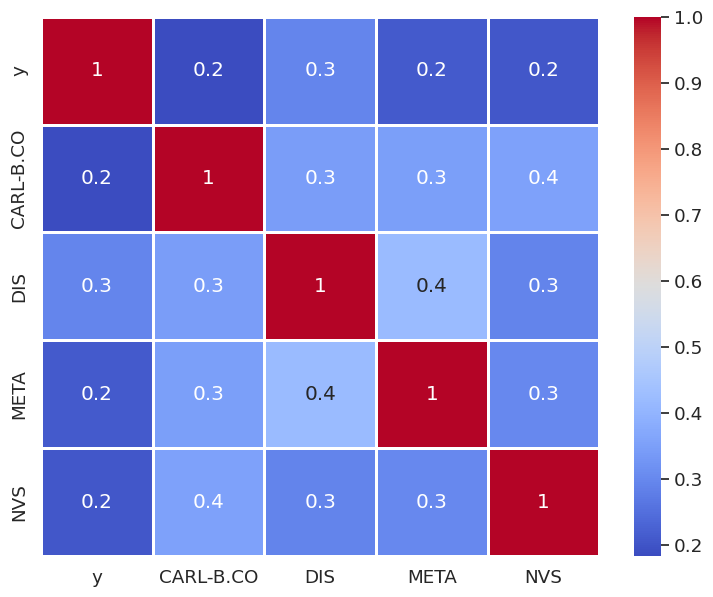

In [33]:
#Correlation Matrix
plt.figure(figsize=(9,7))
sns.set(font_scale=1.2)
sns.heatmap(df_training.pct_change().dropna().corr(),
            annot=True,
            fmt='.1g',
            linewidth=1,
            cmap='coolwarm',
            linecolor='white')

In [34]:
#Removing unwanted time series
df_final=df.drop(columns=["CARL-B.CO"])
df_final.head(1)

,y,DIS,META,NVS
Date,,,,
2018-01-01,121.661171,108.550995,186.850006,61.644344


#Google Causal impact

In [35]:
#prepare pre and post period
pre_period=[training_start,training_end]
post_period=[treatment_start,treatment_end]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


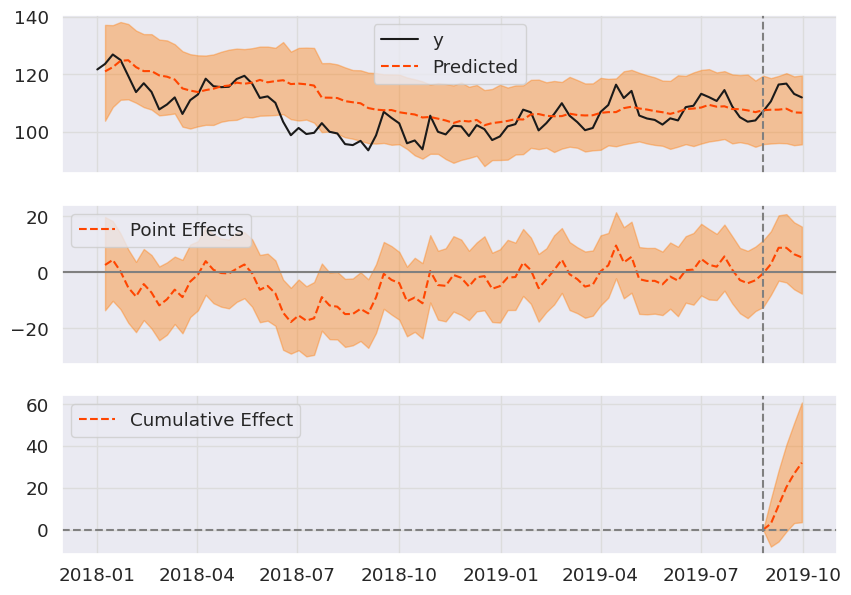

In [36]:
#Google causal impact
impact=CausalImpact(data=df_final,
                    pre_period=pre_period,
                    post_period=post_period)
impact.plot()

In [37]:
#Summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    113.78             568.91
Prediction (s.d.)         107.38 (2.8)       536.88 (14.01)
95% CI                    [101.83, 112.81]   [509.17, 564.07]

Absolute effect (s.d.)    6.41 (2.8)         32.03 (14.01)
95% CI                    [0.97, 11.95]      [4.83, 59.74]

Relative effect (s.d.)    5.97% (2.61%)      5.97% (2.61%)
95% CI                    [0.9%, 11.13%]     [0.9%, 11.13%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 99.1%

For more details run the command: print(impact.summary('report'))


In [38]:
#Summary Report
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 113.78. By contrast, in the absence of an
intervention, we would have expected an average response of 107.38.
The 95% interval of this counterfactual prediction is [101.83, 112.81].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 6.41 with a 95% interval of
[0.97, 11.95]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 568.91.
By contrast, had the intervention not taken place, we would have expected
a sum of 536.88. The 95% interval of this prediction is [509.17, 564.07].


The above results are given in terms of absolute numbers. In relative
terms, the response vari